continuous numbers: [   0    1    1 ... 9998 9998 9999]
(24346, 5)
[0.000e+00 1.000e+00 2.000e+00 ... 9.997e+03 9.998e+03 9.999e+03]
well reco... 0.7983798379837984


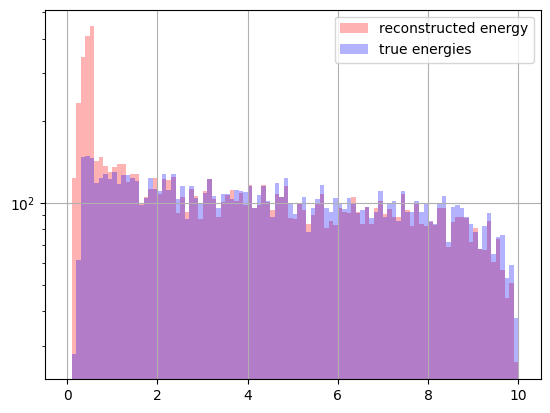

In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
import math 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%run r3b_clustering_def.ipynb

In [2]:
class two_hidden_layer_model(nn.Module):
        def __init__(self,in_features,nodes,hidden_nodes):
                super().__init__()
                self.linear = torch.nn.Linear(in_features,nodes)
                self.another_linear = torch.nn.Linear(nodes,hidden_nodes)
                self.another_linear_two = torch.nn.Linear(hidden_nodes,hidden_nodes)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(hidden_nodes,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                output_tensor = self.activation(output_tensor)
                output_tensor = self.another_linear(output_tensor)
                output_tensor = self.another_linear_two(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor

In [3]:
def train_two_hidden_model(input_data,true_data,in_features,features,learning_rate,hidden_features):
    #n_epochs = 10000
    #for uniform energy use n_epochs x 5
    n_epochs = 50000
    model = two_hidden_layer_model(in_features,features,hidden_features)
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    loss_val = []
    for epoch in range(n_epochs):
        print("epochnr:",epoch,(float(epoch)/float(n_epochs))*100,"%")
        y_pred = model(input_data)
        y_true = true_data
        loss = loss_fn(y_pred,y_true)
        loss_val.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Finished epoch {epoch}, latest loss {loss}')
    ##TJ just uncomment this line for now...
    #plt.plot(loss_val)
    print("this is latest loss val:\t",loss_val[-1])
    #torch.save(model,"ff_scripted.pth")
    torch.save(model.state_dict(),"ff_scripted.pth")
    with torch.no_grad():
        print("hello I am inside no grad")
        model.load_state_dict(torch.load("ff_scripted.pth", weights_only=True))
        #model = torch.load("ff_scripted.pth")
        model.eval()
    eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss_val[-1]

In [4]:
def validate_two_hidden_model(input_data,true_data,in_features,features,learning_rate,hidden_features):
    model = two_hidden_layer_model(in_features,features,hidden_features)
    loss_fn = nn.BCELoss()  # binary cross entropy
    file_path = "ff_scripted.pth"
    model.load_state_dict(torch.load(file_path, weights_only=True))
    model.eval()
    with torch.no_grad():
        y_pred = model(input_data)
        y_true = true_data
        loss = loss_fn(y_pred,y_true)
        eval_pred = model(input_data).detach().numpy()
    return eval_pred,loss
        

In [5]:
def manip_data_ff(data,features):
    ll = []
    true_vals = []
    for i in range(0,int(np.max(data,axis=0)[0])-(int(np.max(data,axis=0)[0])%3) ,3):
        mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
        evt = data[mask]
        pair_indices = list(combinations(range(evt.shape[0]), 2))
        for i, (idx1, idx2) in enumerate(pair_indices):
            l = []
            ### this is the new stuff....
            time_diff = abs(evt[idx1,4]-evt[idx2,4])
            ene_diff = abs(evt[idx1,1]-evt[idx2,1])
            min_theta = evt[idx1,2] if evt[idx2,2] > evt[idx1,2] else evt[idx2,2]
            max_theta = evt[idx2,2] if evt[idx2,2] > evt[idx1,2] else evt[idx1,2]
            theta_diff = abs(max_theta-min_theta) if (abs(max_theta-min_theta) < abs(max_theta-(min_theta+math.pi))) else abs(max_theta-(min_theta+math.pi)) 
            min_phi = evt[idx1,3] if evt[idx2,3] > evt[idx1,3] else evt[idx2,3]
            max_phi = evt[idx2,3] if evt[idx2,3] > evt[idx1,3] else evt[idx1,3]
            phi_diff = abs(max_phi-min_phi) if (abs(max_phi-min_phi) < abs(max_phi-(min_phi+math.pi))) else abs(max_phi-(min_phi+math.pi))
            diff_arr = np.array([ene_diff,theta_diff,phi_diff,time_diff])
            ###following lines I may can remove, only test, or?!?
            test_np = np.concatenate((evt[idx1,1:],evt[idx2,1:]))
            test_np = np.concatenate((test_np,diff_arr))
            ##this is if I also want to add up the sum of the values
            time_sum = abs(evt[idx1,4] + evt[idx2,4])
            ene_sum = abs(evt[idx1,1] + evt[idx2,1])
            theta_sum = abs(evt[idx1,2] + evt[idx2,2])
            sum_arr = np.array([ene_sum,theta_sum,time_sum])
            if (features == 8):
                l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
            if (features == 12):
                l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:],diff_arr)))
            if (features == 15):
                l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:],diff_arr,sum_arr)))
            
            #l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:],diff_arr)))
            ### end of new stuff
            #l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
            ll.append(l)
    
    #print(ll)
    input_data = torch.FloatTensor(ll)
    input_data = torch.squeeze(input_data)
    return input_data

### --- this was old part, just comment out for now ---

In [6]:
# #data = genfromtxt('small_file_correct_coord.txt', delimiter=',')
# data = genfromtxt('test_output_false_negative.txt', delimiter=',') 
# #data = genfromtxt('small_file.txt', delimiter=',')
# #data = genfromtxt('raw_data_test.txt',delimiter=',') ## raw not preclustered data
# data[:,4] =(data[:,4]-np.min(data[:,4]))/(np.max(data[:,4])-np.min(data[:,4]))
# unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
# data[:,0] = continuous_numbers
# data[:,2] = data[:,2]*math.pi/180.
# data[:,3] = data[:,3]*math.pi/180.
# ###TJ test if you are also better without using the time diff
# #data[:,4] = 1

# print(data)

In [7]:
# foo_comb = get_true_combinatorics(data)

In [8]:
# input_data = manip_data_ff(data,12)
# print("data size:",input_data.shape)
# print("true size:",len(foo_comb))
# eval_pred_h2 = train_two_hidden_model(input_data,torch.FloatTensor(foo_comb),12,1000,5e-3,100)


# print("data size:",eval_pred_h2[0].shape )
# print("true_size:",len(foo_comb))
# foo_ene = get_true_reco_ene(data,eval_pred_h2[0].tolist(),foo_comb)

# ##validation
# #validation_output = validate_two_hidden_model(input_data,torch.FloatTensor(foo_comb),12,1000,5e-3,100)



In [9]:
# validation_output = validate_two_hidden_model(input_data,torch.FloatTensor(foo_comb),12,1000,5e-3,100)
# valid_ene = get_true_reco_ene(data,validation_output[0].tolist(),foo_comb)


In [10]:
# pred_binaries = eval_pred_h2[0]
# print(pred_binaries)

# plt.hist(pred_binaries[np.array(foo_comb) == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
# plt.hist(pred_binaries[np.array(foo_comb) == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
# plt.yscale("log")
# plt.grid()
# plt.legend()
# plt.savefig("pred_multi_layer_stuff.png")

### --- end of commenting out ---

### training data

/tmp/ipykernel_612211/2638893087.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  input_data = torch.FloatTensor(ll)


Model's state_dict:
linear.weight 	 torch.Size([1000, 12])
linear.bias 	 torch.Size([1000])
another_linear.weight 	 torch.Size([100, 1000])
another_linear.bias 	 torch.Size([100])
another_linear_two.weight 	 torch.Size([100, 100])
another_linear_two.bias 	 torch.Size([100])
linear_back.weight 	 torch.Size([1, 100])
linear_back.bias 	 torch.Size([1])
epochnr: 0 0.0 %
epochnr: 1 0.002 %
epochnr: 2 0.004 %
epochnr: 3 0.006 %
epochnr: 4 0.008 %
epochnr: 5 0.01 %
epochnr: 6 0.012 %
epochnr: 7 0.013999999999999999 %
epochnr: 8 0.016 %
epochnr: 9 0.018000000000000002 %
epochnr: 10 0.02 %
epochnr: 11 0.022000000000000002 %
epochnr: 12 0.024 %
epochnr: 13 0.026 %
epochnr: 14 0.027999999999999997 %
epochnr: 15 0.03 %
epochnr: 16 0.032 %
epochnr: 17 0.034 %
epochnr: 18 0.036000000000000004 %
epochnr: 19 0.038 %
epochnr: 20 0.04 %
epochnr: 21 0.042 %
epochnr: 22 0.044000000000000004 %
epochnr: 23 0.046 %
epochnr: 24 0.048 %
epochnr: 25 0.05 %
epochnr: 26 0.052 %
epochnr: 27 0.054 %
epochnr: 28 0.0

/home/e12exp/.local/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


well reco... 0.819


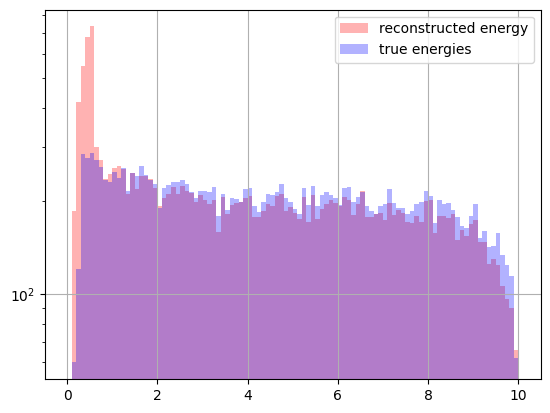

In [11]:
#training_data = genfromtxt('training_all_output_false_negative.txt', delimiter=',')
#training_data = genfromtxt('training_raw.txt', delimiter=',')
##training on raw data with uniform energy distribution between 0.3 MeV and 10 MeV
training_data = genfromtxt('data_raw_uniform_training.csv', delimiter=',')
## some data manipulation needed
training_data[:,4] =(training_data[:,4]-np.min(training_data[:,4]))/(np.max(training_data[:,4])-np.min(training_data[:,4]))
unique_values, continuous_numbers = np.unique(training_data[:,0], return_inverse=True)
training_data[:,0] = continuous_numbers
training_data[:,2] = training_data[:,2]*math.pi/180.
training_data[:,3] = training_data[:,3]*math.pi/180.
training_data[:,4] = 1  ## set time to 1, not sensitive to time, TODO: remove later, just a test
training_true = get_true_combinatorics(training_data)
input_training_data = manip_data_ff(training_data,12) ##second param gives number of features

pred_training = train_two_hidden_model(input_training_data,torch.FloatTensor(training_true),12,1000,5e-3,100)

training_reco = get_true_reco_ene(training_data,pred_training[0].tolist(),training_true)

---

### validation data

well reco... 0.8127812781278128


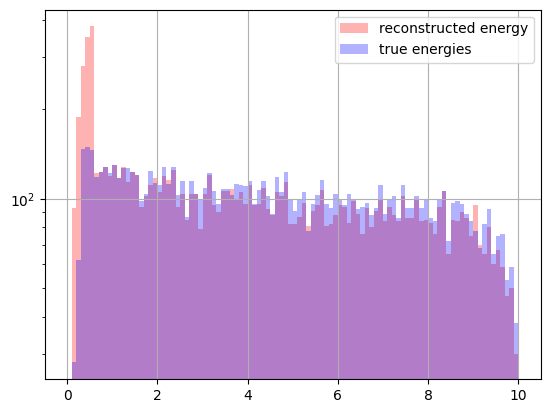

In [12]:
#val_data = genfromtxt('validation_all_output_false_negative.txt', delimiter=',')
#val_data = genfromtxt('validation_raw.txt', delimiter=',')
##test on raw data with uniform energy distribution from 0.3MeV to 10MeV
val_data = genfromtxt('data_raw_uniform_test.csv', delimiter=',')
## some data manipulation needed
val_data[:,4] =(val_data[:,4]-np.min(val_data[:,4]))/(np.max(val_data[:,4])-np.min(val_data[:,4]))
unique_values, continuous_numbers = np.unique(val_data[:,0], return_inverse=True)
val_data[:,0] = continuous_numbers
val_data[:,2] = val_data[:,2]*math.pi/180.
val_data[:,3] = val_data[:,3]*math.pi/180.
val_data[:,4] = 1 ## set time to 1, not sensitive to time, TODO: remove later, just a test
val_true = get_true_combinatorics(val_data)
input_val_data = manip_data_ff(val_data,12) ##second param gives number of features

pred_val = validate_two_hidden_model(input_val_data,torch.FloatTensor(val_true),12,1000,5e-3,100)

val_reco = get_true_reco_ene(val_data,pred_val[0].tolist(),val_true)

#### just test to subsract bin counts

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1
 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9
 9.  9.1 9.2 9.3 9.4 9.5 9.6 9.7 9.8]
(99,)
(99,)


(array([  0.,  69., 128., 133., 226., 206.,   3.,   0.,   1.,  -7.,   2.,
          4.,  -3., -12.,   1.,   0.,  -6.,  -1.,  -9.,  -1.,  -7.,  -6.,
          3.,  -1., -14.,  -5.,  -4.,  -9.,  -7., -17.,  -2.,  -7.,  -8.,
         -4.,   0.,  -6.,   2., -15.,  -4.,  -8.,  -4.,  -6., -11.,  -6.,
         -9.,  -4.,  -9.,  -5., -13.,   0., -15., -12., -10.,   2.,  -3.,
         -8., -10.,  -8., -11., -20.,  -3., -10., -11.,  -8.,  -5., -17.,
         -6.,  -6.,  -4.,  -9.,  -8.,  -3.,  -9.,  -9.,  -5.,  -7.,  -4.,
         -7.,  -9., -11.,  -7.,  -8.,  -5.,  -1.,  -5., -12., -14.,  -8.,
         -5.,  -8.,  18.,   5., -19., -13.,  -6.,  -8., -16.,  -6.,  -8.,
         -9.]),
 array([0.   , 0.098, 0.196, 0.294, 0.392, 0.49 , 0.588, 0.686, 0.784,
        0.882, 0.98 , 1.078, 1.176, 1.274, 1.372, 1.47 , 1.568, 1.666,
        1.764, 1.862, 1.96 , 2.058, 2.156, 2.254, 2.352, 2.45 , 2.548,
        2.646, 2.744, 2.842, 2.94 , 3.038, 3.136, 3.234, 3.332, 3.43 ,
        3.528, 3.626, 3.724, 3.822

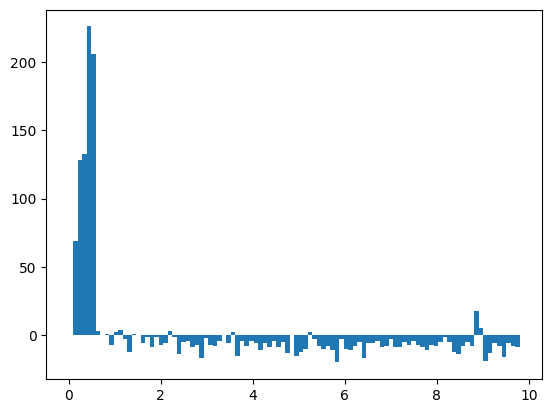

In [13]:
hist1, bins1 = np.histogram(val_reco[0], bins=np.linspace(0, 10, 100))
hist2, bins2 = np.histogram(val_reco[1], bins=np.linspace(0, 10, 100))
residual = (hist1 - hist2)
a = np.arange(0,9.9,0.1)
print(a)
print(a.shape)
print(residual.shape)
plt.hist(a,100, weights=residual)

In [14]:
plt.hist(residual

SyntaxError: unexpected EOF while parsing (4228188815.py, line 1)